# Proximity Metric for Images Belonging to a same phi_{CR} 
# in their Noisy and Non-Noisy Version
---

---

Perhaps in the future it could be interesting to force this in a strictly $phi_{CR}$ basis (with mixed $R_0$ and $w_0$-s).

In [1]:
# This is just a function to allow toggleing code cells that are too long for good
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [2]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import h5py
from time import time
from datetime import datetime
from IPython import display as display_IPython

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define the functions and routines for the DL
### Define the model and its constructor

In [3]:
class Proximity_Metric_Based_On_Simple_Encoder(nn.Module):
    def __init__(self, X=302, feats_1=15, feats_2=20, feats_3=20, feats_4=20,
                 prop1=3, prop2=2, prop3=1, av_pool1_div=4, conv4_feat_size=15, av_pool2_div=10, 
                 out_fc_1=10, out_fc_2=10,
                 dropout_p1=0.2, dropout_p2=0.1
                ): 
        # propj is such that the_ image getting out from stage j is propj/prop_{j-1}-ths of the previous (with j=0 being 5)
        # clearly, prop_{j-1}>prop_{j}>...
        # 2X+1 will be assumed to be divisible by 5
        assert((2*X+1)%5==0)
        assert(prop1>prop2)
        assert(prop2>prop3)
        assert((int((prop3*(2*X+1)/5)/av_pool1_div)-conv4_feat_size)>0)
        
        
        super(Proximity_Metric_Based_On_Simple_Encoder, self).__init__()
        # in is [epoch_size, 1, 2X+1, 2X+1]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=feats_1, 
                               kernel_size = int((2*X+1)/5*(5-prop1)+1), bias=True) 
        # out conv1 [epoch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        self.conv2 = nn.Conv2d(in_channels=feats_1, out_channels=feats_2, 
                               kernel_size = int((2*X+1)/5*(prop1-prop2)+1), bias=True) 
        # out conv1 [epoch_size, feats_2, prop2*(prop1*(2X+1)/5)/prop1, prop2*(prop1*(2X+1)/5)/prop1]
        # that is [epoch_size, feats_2, prop2*(2X+1)/5), prop2*(2X+1)/5)]
        self.conv3 = nn.Conv2d(in_channels=feats_2, out_channels=feats_3, 
                               kernel_size = int((2*X+1)/5*(prop2-prop3)+1), bias=True)
        # out conv3 is [epoch_size, feats_3, prop3*(2X+1)/5), prop3*(2X+1)/5)]

        self.avPool1 = nn.AvgPool2d(kernel_size= int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        
        self.conv4 = nn.Conv2d(in_channels=feats_3, out_channels=feats_4, 
                              kernel_size= int((prop3*(2*X+1)/5)/av_pool1_div+1)-conv4_feat_size+1, bias=True)
        # [epoch_size, feats_4, conv4_feat_size, conv4_feat_size]
        
        self.avPool2 = nn.AvgPool2d(kernel_size= int(conv4_feat_size*(1-1/av_pool2_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_4, conv4_feat_size/av_pool2_div+1, conv4_feat_size/av_pool2_div+1]
        
        #self.in_fc = int(feats_4*(conv4_feat_size/av_pool2_div+1)**2)
        self.in_fc = feats_4*((((((2*X+1-int((2*X+1)/5*(5-prop1)+1)+1)
                                  -int((2*X+1)/5*(prop1-prop2)+1)+1)
                                 -int((2*X+1)/5*(prop2-prop3)+1)+1)
                                -int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) -1+1)
                               -int((prop3*(2*X+1)/5)/av_pool1_div+1)+conv4_feat_size-1+1)
                              -int(conv4_feat_size*(1-1/av_pool2_div)) -1+1)**2
        
        self.fc1 = nn.Linear(in_features=self.in_fc, out_features=out_fc_1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc_1, out_features=out_fc_2, bias=True)
        
        self.dropout1 = nn.Dropout(p=dropout_p1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout_p2, inplace=False)
        self.relu = torch.nn.functional.leaky_relu

        self.batchNorm2 = nn.BatchNorm2d(num_features=feats_2)
        self.batchNorm4 = nn.BatchNorm2d(num_features=feats_4)

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]

        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]

        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]

        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]

        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]

        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]

        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, out_fc_2]
        
        return x
    
    def print_shapes(self, batch_size=10, X=302):
        x = torch.ones((batch_size, 1, 2*X+1, 2*X+1)).to(device)
        print(f"Initial shape {x.shape}")
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        print(f"Post Conv1+relu shape {x.shape}")
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]
        print(f"Post drop1+Conv2+relu+batchnorm shape {x.shape}")
        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]
        print(f"Post drop2+Conv3+relu shape {x.shape}")
        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        print(f"Post Av Pool1 shape {x.shape}")
        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]
        print(f"Post drop2+Conv4+batchnorm shape {x.shape}")
        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
        print(f"Post Av. Pool2 shape {x.shape}")
        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]
        print(f"Post Pre-fc shape {x.shape}")
        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, out_fc2]
        print(f"Post fc1+relu+fc2 shape {x.shape}")

    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                print(f"Params NOT in own state: {name}")
                continue
            if isinstance(param, nn.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            print(f"Params YES in own state: {name} shape on external {param.shape} shape on own {own_state[name].shape}")
            if param.shape==own_state[name].shape:
                own_state[name].copy_(param)




class Proximity_Metric_Based_On_Corrector(nn.Module):
    def __init__(self, S0=2*302+1, S1=2*290+1, S2=2*250+1, S3=2*200+1, S4 = 2*10+1,
                 S5 = 2*1+1, S6 =2,
                 feats_S1=10, feats_S2=10, feats_S3=20, feats_S4=20, feats_S5 = 20,
                 out_fc1=100, out_fc2=10,
                 feats_S6 = 25,
                 dropout_p=0.1
                ): 
       
        super(Proximity_Metric_Based_On_Corrector, self).__init__()
        self.Ss = [S0, S1, S2, S3, S4, S5, S6]
        self.feats = [1, feats_S1, feats_S2, feats_S3, feats_S4, feats_S5, feats_S6]
        self.out_fc1 = out_fc1
        self.out_fc2 = out_fc2
        # in is [batch_size, 1, S0, S0]
        self.conv_S01 = nn.Conv2d(in_channels=1, out_channels=feats_S1, 
                               kernel_size = S0-S1+1, bias=True) 
        # out conv_S01 [batch_size, feats_S1, S1, S1]
        self.conv_S12 = nn.Conv2d(in_channels=feats_S1, out_channels=feats_S2, 
                               kernel_size = S1-S2+1, bias=True) 
        # out conv_S12 [batch_size, feats_S2, S2, S2]
        self.conv_S23 = nn.Conv2d(in_channels=feats_S2, out_channels=feats_S3, 
                               kernel_size = S2-S3+1, bias=True) 
        # out conv_S23 [batch_size, feats_S3, S3, S3]
        
        self.conv_S33 = nn.Conv2d(in_channels=feats_S3, out_channels=feats_S3, 
                               kernel_size = 1, bias=True) 
        # out conv_S33 [batch_size, feats_S3, S3, S3]
        
        self.conv_S34 = nn.Conv2d(in_channels=feats_S3, out_channels=feats_S4, 
                               kernel_size = S3-S4+1, bias=True) 
        # out conv_S34 [batch_size, feats_S4, S4, S4]
        
        self.conv_S45 = nn.Conv2d(in_channels=feats_S4, out_channels=feats_S5, 
                               kernel_size = S4-S5+1, bias=True) 
        # out conv_S45 [batch_size, feats_S5, S5, S5]
        self.conv_S56 = nn.Conv2d(in_channels=feats_S5, out_channels=feats_S6, 
                               kernel_size = S5-S6+1, bias=True) 
        # out conv_S56 [batch_size, feats_S6, S6, S6]
        
        self.in_fc1 = S6*S6*feats_S6
        self.fc1 = nn.Linear(in_features=self.in_fc1, out_features=out_fc1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc1, out_features=out_fc2, bias=True)
        
        self.dropout = nn.Dropout(p=dropout_p, inplace=False)
        self.relu = torch.nn.functional.leaky_relu

        self.batchNorm1 = nn.BatchNorm2d(num_features=feats_S3)
        self.batchNorm2 = nn.BatchNorm1d(num_features=out_fc1)
        

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        # Conv layers
        x = self.relu(self.conv_S01(x)) # [batch_size, feats_S1, S1, S1]
        x = self.dropout( self.relu(self.conv_S12(x)) ) # [batch_size, feats_S2, S2, S2]
        x = self.relu(self.conv_S23(x)) # [batch_size, feats_S3, S3, S3]
        x = self.batchNorm1(self.relu(self.conv_S33(x)))
        x = self.relu(self.conv_S34(x))
        x = self.relu(self.conv_S45(x))
        x = self.relu(self.conv_S56(x))
        
        x = x.view(x.shape[0], self.in_fc1)
        x = self.dropout( self.relu(self.batchNorm2(self.fc1(self.dropout(x)))) )
        return self.fc2(x)

        
    def print_shapes(self, batch_size=10):
        x = torch.ones((batch_size, 1, self.Ss[0], self.Ss[0])).to(device)
        print(f"Initial shape {x.shape}")
        x = self.relu(self.conv_S01(x)) # [batch_size, feats_S1, S1, S1]
        print(f"Conv01 shape {x.shape} should be [{batch_size},{self.feats[1]},{self.Ss[1]}, {self.Ss[1]}]")
        x = self.dropout( self.relu(self.conv_S12(x)) ) # [batch_size, feats_S2, S2, S2]
        print(f"Conv12 shape {x.shape} should be [{batch_size},{self.feats[2]},{self.Ss[2]}, {self.Ss[2]}]")
        x = self.batchNorm1( self.relu(self.conv_S23(x)) ) # [batch_size, feats_S3, S3, S3]
        print(f"Conv23 shape {x.shape} should be [{batch_size},{self.feats[3]},{self.Ss[3]}, {self.Ss[3]}]")
        x = self.relu(self.conv_S34(x))  # [batch_size, feats_S3, S3, S3]
        print(f"Conv34 shape {x.shape} should be [{batch_size},{self.feats[4]},{self.Ss[4]}, {self.Ss[4]}]")
        x = self.relu(self.conv_S45(x))  # [batch_size, feats_S3, S3, S3]
        print(f"Conv45 shape {x.shape} should be [{batch_size},{self.feats[5]},{self.Ss[5]}, {self.Ss[5]}]")
        x = self.relu(self.conv_S56(x))  # [batch_size, feats_S3, S3, S3]
        print(f"Conv56 shape {x.shape} should be [{batch_size},{self.feats[6]},{self.Ss[6]}, {self.Ss[6]}]")
        x = x.view(x.shape[0], self.in_fc1)
        print(f"Input to fc1 is {x.shape} should be [{batch_size}, {self.in_fc1}]")
        x = self.dropout( self.relu(self.batchNorm2(self.fc1(self.dropout(x)))) )
        print(f"Output of fc1 is {x.shape} should be [{batch_size}, {self.out_fc1}]")
        x= self.fc2(x)
        print(f"Output of fc2 is {x.shape} should be [{batch_size}, {self.out_fc2}]")
    
    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                print(f"Params NOT in own state: {name}")
                continue
            if isinstance(param, nn.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            print(f"Params YES in own state: {name} shape on external {param.shape} shape on own {own_state[name].shape}")
            if param.shape==own_state[name].shape:
                own_state[name].copy_(param)

In [4]:
hide_toggle(for_next=True)


In [5]:
# subroutine to count number of parameters in the model
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

### The routines to validate and train

In [6]:
hide_toggle(for_next=True)


In [7]:
def train_epoch(epoch, triplet_losses, model, optimizer, dataloader, print_loss_every_batches=20,
                optimizer_step_every_batches=1, per_epoch_use_max_batches=None):
    if per_epoch_use_max_batches is None:
        per_epoch_use_max_batches = len(dataloader)
        
    total_loss = 0.0

    model.train()

    optimizer.zero_grad()

    for batch_id in range(per_epoch_use_max_batches):  
        data = dataloader[batch_id] # [PK, 2X+1, 2X+1] dataloader sends them to device already
        embeddings = model(data) # embeddings is [PK, embedding_dim]
        loss = torch.sum( triplet_losses.forward(embeddings) )
        loss.backward()
        
        if batch_id % optimizer_step_every_batches==optimizer_step_every_batches-1:
            optimizer.step()
            optimizer.zero_grad()
        # print loss every N batches
        if batch_id % print_loss_every_batches == print_loss_every_batches-1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_id+1) * len(data), len(data)*per_epoch_use_max_batches,
                100*(batch_id+1)*len(data) / (len(data)*per_epoch_use_max_batches), loss.item()))

        #if batch_id % per_epoch_use_max_batches == per_epoch_use_max_batches-1:
        #    break

        total_loss += loss.item()  #.item() is very important here

    return total_loss / min(len(dataloader), per_epoch_use_max_batches)


def train_epoch_monitor_everything(epoch, triplet_losses, model, optimizer, dataloader,
                print_loss_every_batches, optimizer_step_every_batches,
                epoch_av_loss, epoch_av_non_zero_loss,
                epoch_q_loss, epoch_q_dist_embs, epoch_q_norm_embs,
                percentiles,
                tolerance_zero_loss = 0, per_epoch_use_max_batches=None):
    if per_epoch_use_max_batches is None:
        per_epoch_use_max_batches = len(dataloader)
    
    # initialize batch metrics
    epoch_av_loss.append(  0.0  )
    epoch_av_non_zero_loss.append( 0.0 )
    epoch_q_loss.append(  np.zeros((len(percentiles)))  )
    epoch_q_dist_embs.append(  np.zeros((len(percentiles)))  )
    epoch_q_norm_embs.append(  np.zeros((len(percentiles)))  )

        
    model.train()

    optimizer.zero_grad()

    for batch_id in range(per_epoch_use_max_batches):  
        data = dataloader[batch_id] # [PK, 2X+1, 2X+1] dataloader sends them to device already
        embeddings = model(data) # embeddings is [PK, embedding_dim]
        losses = triplet_losses.forward(embeddings) 
        loss = torch.sum(losses)
        loss.backward()
        
        epoch_av_loss[-1] += loss.item()/per_epoch_use_max_batches # we divide it here to avoid overflowing it
        epoch_q_loss[-1] += torch.quantile(losses, percentiles, dim=0).detach().to('cpu').numpy()
        epoch_q_dist_embs[-1] += torch.quantile( triplet_losses.D[triplet_losses.triu_indices[0], 
                                                               triplet_losses.triu_indices[1]],
                                            percentiles, dim=0).detach().to('cpu').numpy()
        epoch_q_norm_embs[-1] += torch.quantile(torch.norm(embeddings, dim=1), percentiles, dim=0).detach().to('cpu').numpy()
        epoch_av_non_zero_loss[-1] += torch.sum(losses>tolerance_zero_loss).item()/losses.shape[0]
        
        if batch_id % optimizer_step_every_batches==optimizer_step_every_batches-1:
            optimizer.step()
            optimizer.zero_grad()
        # print loss every N batches
        if batch_id % print_loss_every_batches == print_loss_every_batches-1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_id+1) * len(data), len(data)*per_epoch_use_max_batches,
                100*(batch_id+1)*len(data) / (len(data)*per_epoch_use_max_batches), loss.item()))
            
        # Detach the matrix we are reusing
        #print(triplet_losses.D.grad, triplet_losses.D.requires_grad)


    # make them average values among the batches
    epoch_q_loss[-1] /= per_epoch_use_max_batches
    epoch_q_dist_embs[-1] /= per_epoch_use_max_batches
    epoch_q_norm_embs[-1] /= per_epoch_use_max_batches
    epoch_av_non_zero_loss[-1] /= per_epoch_use_max_batches

### The full training loop

In [8]:
hide_toggle(for_next=True)


In [9]:
def full_training_loop(model, criterion, optimizer, train_loader, epochs=10,
                       print_loss_every_batches=20, optimizer_step_every_batches=1,
                      per_epoch_use_max_train_batches=None,
                      image_path=None, save_model_every_epochs=1, model_path=None, best_model_path=None):
    losses = {"train": []}
    %matplotlib inline
    for epoch in range(epochs):

        train_loss = train_epoch(epoch, criterion, model, optimizer, train_loader,
                                 print_loss_every_batches=print_loss_every_batches,
                                optimizer_step_every_batches=optimizer_step_every_batches,
                                per_epoch_use_max_batches=per_epoch_use_max_train_batches)
        
        if epoch and train_loss<=min(losses["train"]) and best_model_path:
            torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, best_model_path)
        
        losses["train"].append(train_loss)
        plt.plot(losses["train"], label="training loss")
        #plt.yscale('log')
        plt.legend()
        if image_path is not None:
            plt.savefig(image_path)
            plt.clf()
        else:
            display_IPython.clear_output(wait=True)
            plt.pause(0.001)
            plt.show()
        if epoch % save_model_every_epochs==save_model_every_epochs-1 and model_path:
            torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, model_path)

    return losses


from cycler import cycler
def full_training_loop_monitor_everything(model, criterion, optimizer, train_loader, epochs=10,
                       print_loss_every_batches=20, plot_metrics_every_epochs=1, optimizer_step_every_batches=1,
                      per_epoch_use_max_train_batches=None,
                      image_path=None, save_model_every_epochs=1, model_path=None, best_model_path=None,
                                         percentiles=[0.1, 0.5, 0.9]):

    # prepare the metric monitorers
    epoch_av_loss=[]
    epoch_av_non_zero_loss=[]
    epoch_q_loss=[]
    epoch_q_dist_embs=[]
    epoch_q_norm_embs=[]
    min_loss = float('inf')
    
    # prepare the metric plot figure
    %matplotlib inline
    fig, ax_array = plt.subplots(2, 2, figsize=(10,10))
    for i in range(2):
        for j in range(2):
            ax_array[i,j].set_xlabel("Epoch")
    ax_array[0,0].set_title("Triplet Loss Percentiles averaged\n over batches in epoch")
    ax_array[0,0].set_ylabel("Loss")
    ax_array[0,1].set_title("Average non-zero loss in Batch (over epoch)")
    ax_array[0,1].set_ylabel("Ratio of non-zero losses")
    ax_array[1,0].set_title("Distance Between Embedding Percentiles\n averaged over batches in epoch")
    ax_array[1,0].set_ylabel("Distance")
    ax_array[1,1].set_title("Magnitude of Embeddings Percentiles\n averaged over batches in epoch")
    ax_array[1,1].set_title("Norm")
    artists=[]
    ps = np.array(percentiles.to('cpu'))
    met_epochs=np.arange( 0, epoch, 1)
    fig.subplots_adjust(hspace=0.6)

    for epoch in range(epochs):

        train_epoch_monitor_everything(epoch, criterion, model, optimizer, train_loader,
                                print_loss_every_batches=print_loss_every_batches,
                                optimizer_step_every_batches=optimizer_step_every_batches,
                                epoch_av_loss=epoch_av_loss, 
                                epoch_av_non_zero_loss=epoch_av_non_zero_loss,
                                epoch_q_loss=epoch_q_loss,
                                epoch_q_dist_embs=epoch_q_dist_embs,
                                epoch_q_norm_embs=epoch_q_norm_embs,
                                percentiles=percentiles,
                                per_epoch_use_max_batches=per_epoch_use_max_train_batches)
        
        
        if epoch and epoch_av_loss[-1] <= min_loss and best_model_path:
            min_loss = epoch_av_loss[-1]
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                }, best_model_path)
        
        if epoch % plot_metrics_every_epochs==plot_metrics_every_epochs-1:

            artists += ax_array[0,0].plot(met_epochs[:epoch+1], np.array(epoch_q_loss), label=ps)
            artists += ax_array[0,0].plot(met_epochs[:epoch+1], epoch_av_loss, label="Average", color="r")
            artists += ax_array[0,1].plot(met_epochs[:epoch+1], epoch_av_non_zero_loss, label="Average"  )
            artists += ax_array[1,0].plot(met_epochs[:epoch+1], np.array(epoch_q_dist_embs), label=ps)
            artists += ax_array[1,1].plot(met_epochs[:epoch+1], np.array(epoch_q_norm_embs), label=ps)

            for ax in ax_array.flatten():
                ax.set_prop_cycle(cycler('color', ["#1f77b4", "#ff7f0e", "#2ca02c"]))
                ax.legend()

            if image_path is not None:
                plt.savefig(image_path)
                for artist in artists:
                    artist.remove()
                artists=[]
            else:
                display_IPython.clear_output(wait=True)
                plt.pause(0.001)
                plt.show()
                artists=[]
                
        if epoch % save_model_every_epochs==save_model_every_epochs-1 and model_path:
            torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, model_path)

    return losses

def full_training_loop_monitor_partially(model, criterion, optimizer, train_loader, epochs=10,
                       print_loss_every_batches=20, compute_metrics_every_epochs=2, plot_metrics_every_epochs=5, 
                    optimizer_step_every_batches=1,
                      per_epoch_use_max_train_batches=None,
                      image_path=None, save_model_every_epochs=1, model_path=None, best_model_path=None,
                                         percentiles=[0.1, 0.5, 0.9]):
    assert plot_metrics_every_epochs>=compute_metrics_every_epochs, "Do not need to plot so frequently!"
    # prepare the metric monitorers
    epoch_av_loss=[]
    epoch_av_non_zero_loss=[]
    epoch_q_loss=[]
    epoch_q_dist_embs=[]
    epoch_q_norm_embs=[]
    min_loss = float('inf')
    ps = np.array(percentiles.to('cpu'))
    
    # prepare the metric plot figure
    %matplotlib inline
    fig, ax_array = plt.subplots(2, 2, figsize=(10,10))
    for i in range(2):
        for j in range(2):
            ax_array[i,j].set_xlabel("Epoch")
    ax_array[0,0].set_title("Triplet Loss Percentiles averaged\n over batches in epoch")
    ax_array[0,0].set_ylabel("Loss")
    ax_array[0,1].set_title("Average non-zero loss in Batch (over epoch)")
    ax_array[0,1].set_ylabel("Ratio of non-zero losses")
    ax_array[1,0].set_title("Distance Between Embedding Percentiles\n averaged over batches in epoch")
    ax_array[1,0].set_ylabel("Distance")
    ax_array[1,1].set_title("Magnitude of Embeddings Percentiles\n averaged over batches in epoch")
    ax_array[1,1].set_title("Norm")
    artists=[]
    fig.subplots_adjust(hspace=0.6)
    met_epochs=np.arange(compute_metrics_every_epochs-1, epochs, compute_metrics_every_epochs)

    
    for epoch in range(epochs):
        if epoch % compute_metrics_every_epochs==compute_metrics_every_epochs-1:
            
            train_epoch_monitor_everything(epoch, criterion, model, optimizer, train_loader,
                                print_loss_every_batches=print_loss_every_batches,
                                optimizer_step_every_batches=optimizer_step_every_batches,
                                epoch_av_loss=epoch_av_loss, 
                                epoch_av_non_zero_loss=epoch_av_non_zero_loss,
                                epoch_q_loss=epoch_q_loss,
                                epoch_q_dist_embs=epoch_q_dist_embs,
                                epoch_q_norm_embs=epoch_q_norm_embs,
                                percentiles=percentiles,
                                per_epoch_use_max_batches=per_epoch_use_max_train_batches)
           
            if epoch % plot_metrics_every_epochs==plot_metrics_every_epochs-1:

                artists += ax_array[0,0].plot(met_epochs[:epoch+1], np.array(epoch_q_loss), label=ps)
                artists += ax_array[0,0].plot(met_epochs[:epoch+1], epoch_av_loss, label="Average", color="r")
                artists += ax_array[0,1].plot(met_epochs[:epoch+1], epoch_av_non_zero_loss, label="Average" )
                artists += ax_array[1,0].plot(met_epochs[:epoch+1], np.array(epoch_q_dist_embs), label=ps)
                artists += ax_array[1,1].plot(met_epochs[:epoch+1], np.array(epoch_q_norm_embs), label=ps)

                for ax in ax_array.flatten():
                    ax.set_prop_cycle(cycler('color', ["#1f77b4", "#ff7f0e", "#2ca02c"]))
                    ax.legend()

                if image_path is not None:
                    plt.savefig(image_path)
                    for artist in artists:
                        artist.remove()
                    artists=[]
                else:
                    display_IPython.clear_output(wait=True)
                    plt.pause(0.001)
                    plt.show()
                    artists=[]
        else:
            train_epoch(epoch, criterion, model, optimizer, train_loader, print_loss_every_batches,
                optimizer_step_every_batches, per_epoch_use_max_batches)
        
        
        if epoch and epoch_av_loss[-1] <= min_loss and best_model_path:
            min_loss = epoch_av_loss[-1]
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                }, best_model_path)
        
                
        if epoch % save_model_every_epochs==save_model_every_epochs-1 and model_path:
            torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, model_path)

    return epoch_av_loss, epoch_av_non_zero_loss, epoch_q_loss, epoch_q_dist_embs, epoch_q_norm_embs, min_loss

### The Dataset class and Data Sampler

In [10]:
hide_toggle(for_next=True)

In [11]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class ImageDataloader(Dataset):
    def __init__(self, GT_file_path, h5f_full_path, P, K, produce_batches_per_epoch):
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(GT_file_path))) 
        # Que te linkee el nombre de la entrada del h5f (un index del batch) con los ground truth phis

        self.h5f = h5py.File(f"{h5f_full_path}", 'r')
        self.num_diff_perfs = len(self.h5f)
        shape = self.h5f[ str(self.df_GTs.iloc[0]['ID']) ].shape
        self.max_K = shape[0]
        self.image_size = shape[1:]
        print(f"There are {self.num_diff_perfs} total different classes (w0,R0,phiCR) triplets.")
        print(f"For each of them, there are the denoised and {self.max_K-1} noisy versions")
        print(f"Each image is of shape {self.image_size}")
        print(f"A total of {self.num_diff_perfs*self.max_K} different images in the dataset, with their GT phiCRs")
        self.K = min(K, self.max_K) # number of versions of each class to employ per batch
        self.P = P # number of different "classes" to employ per batch
        self.PK = self.K*self.P
        self.produce_batches_per_epoch = produce_batches_per_epoch
        
    def __len__(self):
        return self.produce_batches_per_epoch

    def __getitem__(self, idx):
        # sudar olimplicamente del idx y simplemente devolver una combinación que tenga que ser aleatoria
        random_indices = np.random.choice(range(self.num_diff_perfs), self.P, replace=False)
        data = torch.zeros((self.P, self.K, self.image_size[0], self.image_size[1]), 
                          device=device, dtype=torch.float32) # [P,K,2X+1,2X+1]
        #gt_phiCR = torch.zeros((self.P, 1), device=device, dtype=torch.float32) #[P,1]
        for i,ind in enumerate(random_indices):
             data[i,:,:,:] = torch.tensor( np.array(self.h5f[str(ind)]), device=device, dtype=torch.float32 ) 
            #gt_phiCR[i] = self.df_GTs['ID'==str(i)]['phiCR']
        return data.reshape((self.PK, self.image_size[0], self.image_size[1])) #, gt_phiCR
    # we return the data as [PK, 2X+1, 2X+1] where the first K in axis 0 belong to a same anchor P, next
    # K to a different same anchor etc.
    # solo devuelve las imagenes ya subidas a la gpu, luego fuera hay que hacer el cómputo de la métrica
    # y hacer el pairwise todo!
    
    def get_im_and_label(self):
        random_indices = np.random.choice(range(self.num_diff_perfs), self.P, replace=False)
        data = torch.zeros((self.P, self.K, self.image_size[0], self.image_size[1]), 
                          device=device, dtype=torch.float32) # [P,K,2X+1,2X+1]
        gt_phiCR = torch.zeros((self.P, 1), device=device, dtype=torch.float32) #[P,1]
        for i,ind in enumerate(random_indices):
            data[i,:,:,:] = torch.tensor( np.array(self.h5f[str(ind)]), device=device, dtype=torch.float32 ) 
            gt_phiCR[i] = float(self.df_GTs[self.df_GTs['ID']==i]['phiCR'].item())
        return data.reshape((self.PK, self.image_size[0], self.image_size[1])), gt_phiCR


## The Triplet Losses

In [12]:
class batch_hard_losses_hard_margin():#torch.autograd.Function):
    def __init__(self, m, P, K):
        #super(batch_hard_losses_hard_margin, self).__init__()
        self.margin = m
        self.P=P
        self.K=K
        self.PK=P*K
        self.relu = nn.ReLU()
        
        # we will NOT reuse the table of distances matrix, for the gradient to be computed correctly
        #self.D = torch.zeros((self.PK, self.PK), device=device) #[PK, PK]
        
        # also the indices for upper triangular access
        self.triu_indices = torch.triu_indices(row=self.PK, col=self.PK, offset=1) # indices for upper triangular

        # Let us now build the indices for negative and positive selection
        ones_block=torch.ones((K,K), dtype=torch.bool, device=device)
        self.diagonal_KxK_blocks_are_one = torch.kron(torch.eye(P, dtype=torch.bool, device=device), ones_block)
        #diagonal_KxK_blocks_are_zero = torch.logical_not(diagonal_KxK_blocks_are_one)

    #@staticmethod
    def forward(self, embeddings):
        # Embeddings are expected to be in the format [PK,embedding_dim]
        # where the K first belong to a same P, the next K to a different P etc.
        # we can achieve this by reshaping [P,K,embedding_dim] to [PK, embedding_dim]
        # We first need to get the [0.5*PK*(PK-1)] relative distances Only strictly necessary distances computed
        distances = torch.pdist(embeddings, p=2)
        
        self.D = torch.zeros((self.PK, self.PK), device=device) #[PK, PK]
        # We will build here the relative distances table
        self.D[self.triu_indices[0], self.triu_indices[1]] = distances
        self.D.T[self.triu_indices[0], self.triu_indices[1]] = distances
        # Now D is the relative distances matrix (with zeros in diagonal)

        
        positives = torch.where(self.diagonal_KxK_blocks_are_one, 
                                self.D, torch.tensor([0.0], device=device))
        negatives = torch.where(self.diagonal_KxK_blocks_are_one, 
                                torch.tensor([torch.inf], device=device), self.D)

        hard_positives = torch.max(positives, axis=0)[0]
        hard_negatives = torch.min(negatives, axis=0)[0]

        return self.relu(self.margin+hard_positives-hard_negatives) #[PK] losses returned. Overall loss will be the sum

    
class batch_hard_losses_soft_margin():#torch.autograd.Function):
    def __init__(self, P, K):
        #super(batch_hard_losses_soft_margin, self).__init__()
        self.P=P
        self.K=K
        self.PK=P*K
        self.softplus = nn.Softplus()
        
        # we will NOT reuse the table of distances matrix for the gradients to be computed correctly
        #self.D = torch.zeros((self.PK, self.PK), device=device) #[PK, PK]
        
        # also the indices for upper triangular access
        self.triu_indices = torch.triu_indices(row=self.PK, col=self.PK, offset=1) # indices for upper triangular

        # Let us now build the indices for negative and positive selection
        ones_block=torch.ones((K,K), dtype=torch.bool, device=device)
        self.diagonal_KxK_blocks_are_one = torch.kron(torch.eye(P, dtype=torch.bool, device=device), ones_block)
        #diagonal_KxK_blocks_are_zero = torch.logical_not(diagonal_KxK_blocks_are_one)

    #@staticmethod
    def forward(self, embeddings):
        # Embeddings are expected to be in the format [PK,embedding_dim]
        # where the K first belong to a same P, the next K to a different P etc.
        # we can achieve this by reshaping [P,K,embedding_dim] to [PK, embedding_dim]
        # We first need to get the [0.5*PK*(PK-1)] relative distances Only strictly necessary distances computed
        distances = torch.pdist(embeddings, p=2)
        
        # We will build here the relative distances table
        self.D = torch.zeros((self.PK, self.PK), device=device) #[PK, PK]

        self.D[self.triu_indices[0], self.triu_indices[1]] = distances
        self.D.T[self.triu_indices[0], self.triu_indices[1]] = distances
        # Now D is the relative distances matrix (with zeros in diagonal)

        
        positives = torch.where(self.diagonal_KxK_blocks_are_one, 
                                self.D, torch.tensor([0.0], device=device))
        negatives = torch.where(self.diagonal_KxK_blocks_are_one, 
                                torch.tensor([torch.inf], device=device), self.D)

        hard_positives = torch.max(positives, axis=0)[0]
        hard_negatives = torch.min(negatives, axis=0)[0]

        return self.softplus(hard_positives-hard_negatives) #[PK] losses returned (the overall loss will be the sum)


---
# Initialize the dataset and sampler (choose the number of batches per epoch, and their length) and fix the artificial noise hyperparameters

Note that since in each epoch the dataset shown to the model will be random, we can use the same dataset as a validation set.

In [13]:
dataset_path = "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/Noisy_Non_Noisy_same_angle/"
GT_file_path_train = f"{dataset_path}/TRAIN/GROUND_TRUTHS_K=4_Noisy_Non_Noisy_same_angle.json"
images_h5_path_train = f"{dataset_path}/TRAIN/Dataset_K=4_Noisy_Non_Noisy_same_angle.h5" 
GT_file_path_test = f"{dataset_path}/TRAIN/GROUND_TRUTHS_K=4_Noisy_Non_Noisy_same_angle.json"
images_h5_path_test = f"{dataset_path}/TRAIN/Dataset_K=4_Noisy_Non_Noisy_same_angle.h5" 

save_stuff_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Proximity_Metric/"

total_epochs = 10000
optimizer_step_every_batches = 1
per_epoch_use_max_train_batches= 1
save_model_every_epochs = 1
torch.manual_seed(678)
compute_metrics_every_epochs=1
plot_metrics_every_epochs=1

percentiles=torch.tensor([0.1,0.5,0.9], device=device)

K=4
P=3
margin=10

#exp_name='Proximity_Metric_from_Image_Corrector'+'_Batch_Hard_Margin'
exp_name='Proximity_Metric_from_Simple_Encoder'+'_Batch_Hard_Margin'
#exp_name='Proximity_Metric_from_Image_Corrector'+'_Batch_Hard_Soft_Margin'
#exp_name='Proximity_Metric_from_Simple_Encoder'+'_Batch_Hard_Soft_Margin'


In [14]:
training_data = ImageDataloader(GT_file_path_train, images_h5_path_train, P, K, per_epoch_use_max_train_batches)

There are 50000 total different classes (w0,R0,phiCR) triplets.
For each of them, there are the denoised and 3 noisy versions
Each image is of shape (605, 605)
A total of 200000 different images in the dataset, with their GT phiCRs


# Fix the Hyperparameters and Initialize the Model and the Optimizer

In [15]:
# DENOISER BASED METRIC ############
X=302
S0=2*X+1
S1=2*250+1
S2=2*200+1
S3=2*150+1
S4=2*10+1
S5=2*1+1
S6=2
feats_S1=5
feats_S2=5
feats_S3=10
feats_S4=20
feats_S5=20
feats_S6=25
out_fc1=100
dropout_p=0.1

# SIMPLE ENCODER TO phiCR BASED METRIC ###########
X=302
feats_1=20
feats_2=20
feats_3=20
feats_4=5
prop1=2.5
prop2=1.5
prop3=0.6
av_pool1_div=2
conv4_feat_size=8
av_pool2_div=10
out_fc_1=5
dropout_p1=0.2
dropout_p2=0.1


# FOR BOTH, THE EMBEDDING SPACE DIMENSION WILL BE CHOSEN BY
out_fc2=10

In [16]:
'''
model = Proximity_Metric_Based_On_Corrector(S0=S0, S1=S1, S2=S2, S3=S3, S4=S4, S5=S5, S6=S6,
                 feats_S1=feats_S1, feats_S2=feats_S2, feats_S3=feats_S3, feats_S4=feats_S4,
                 feats_S5=feats_S5, feats_S6=feats_S6,
                 out_fc1=out_fc1, out_fc2=out_fc2,
                 dropout_p=dropout_p ) 

'''
model = Proximity_Metric_Based_On_Simple_Encoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                 prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, 
                av_pool2_div=av_pool2_div, 
                 out_fc_1=out_fc_1, out_fc_2=out_fc2,
                 dropout_p1=dropout_p1, dropout_p2=dropout_p2 ) 


print(f"Number of parameters {get_n_params(model)}")

# In case we wish to transfer the learned parameters of another run
check_file="BEST_Noisy_Model_and_Optimizer_2022-03-01 18:08:09.693062_Simple_Encoder.pt"
#checkpoint = torch.load(save_stuff_path+f"/NNs/{check_file}")
checkpoint = torch.load('/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/'+f"/NNs/{check_file}")

# move model to gpu if available
model.to(device)
model.print_shapes(batch_size=3)

print("\n")
model.load_my_state_dict(checkpoint['model'])


# Initialize the weights of the model! Default initialization might already be fine!

# Triplet loss initialization
loss = batch_hard_losses_hard_margin(margin, P, K)
#loss = batch_hard_losses_soft_margin( P, K)

# we will choose as optimizer the 
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.01, weight_decay=0.3,
#                                initial_accumulator_value=0, eps=1e-10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer.load_state_dict(checkpoint['optimizer'])

Number of parameters 12632460
Initial shape torch.Size([3, 1, 605, 605])
Post Conv1+relu shape torch.Size([3, 20, 303, 303])
Post drop1+Conv2+relu+batchnorm shape torch.Size([3, 20, 182, 182])
Post drop2+Conv3+relu shape torch.Size([3, 20, 74, 74])
Post Av Pool1 shape torch.Size([3, 20, 38, 38])
Post drop2+Conv4+batchnorm shape torch.Size([3, 5, 9, 9])
Post Av. Pool2 shape torch.Size([3, 5, 2, 2])
Post Pre-fc shape torch.Size([3, 20])
Post fc1+relu+fc2 shape torch.Size([3, 10])


Params YES in own state: conv1.weight shape on external torch.Size([20, 1, 303, 303]) shape on own torch.Size([20, 1, 303, 303])
Params YES in own state: conv1.bias shape on external torch.Size([20]) shape on own torch.Size([20])
Params YES in own state: conv2.weight shape on external torch.Size([20, 20, 122, 122]) shape on own torch.Size([20, 20, 122, 122])
Params YES in own state: conv2.bias shape on external torch.Size([20]) shape on own torch.Size([20])
Params YES in own state: conv3.weight shape on extern

# Run the Training

Train Epoch: 0 [12/12 (100%)]	Loss: 97.100746


KeyboardInterrupt: 

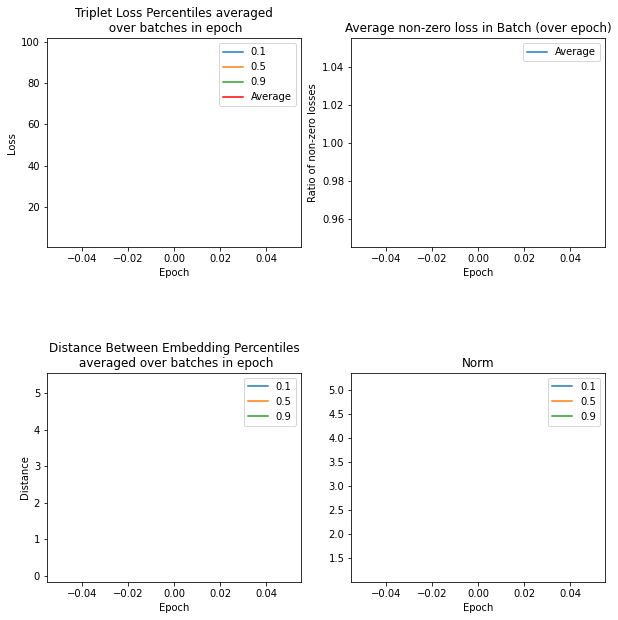

In [17]:
%%time
losses = full_training_loop_monitor_partially(model, loss, optimizer, training_data, 
                    epochs=total_epochs, print_loss_every_batches=1,
                            compute_metrics_every_epochs=compute_metrics_every_epochs,
                            plot_metrics_every_epochs=plot_metrics_every_epochs,
                           optimizer_step_every_batches=optimizer_step_every_batches,
                           per_epoch_use_max_train_batches=per_epoch_use_max_train_batches, 
                           image_path=save_stuff_path+ f"/Training_Loss_{datetime.now()}_{exp_name}.png",
                           save_model_every_epochs=save_model_every_epochs, 
                            model_path=save_stuff_path+f"/Model_and_Optimizer_{datetime.now()}_{exp_name}.pt",
                            best_model_path=save_stuff_path+f"/BEST_Model_and_Optimizer_{datetime.now()}_{exp_name}.pt",
                            percentiles=percentiles
                           )
# Execute the training and validation

# Save the resulting model weights

In [18]:
torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, save_stuff_path+f"/FINAL_Model_and_Optimizer_{datetime.now()}_{exp_name}.pt")

# Final Validation
For the validation of the Embedding, we could check the following ones:
    
$\quad$   **(a)** Embedd some random samples and project them to 3D and 2D space using PCA and UMAP, to check the performance visually.
   
$\quad$   **(b)** Use it in a simulation fit algorithm as a metric for the image fit.
   
$\quad$   **(c)** Use it as a KNN distance metric on a huge library of GT angle images.

# (a)

In [19]:
P_to_embedd = 100
K_to_embedd = K

test_data = ImageDataloader(GT_file_path_test, images_h5_path_test, 1, K_to_embedd, 1)

There are 50000 total different classes (w0,R0,phiCR) triplets.
For each of them, there are the denoised and 3 noisy versions
Each image is of shape (605, 605)
A total of 200000 different images in the dataset, with their GT phiCRs


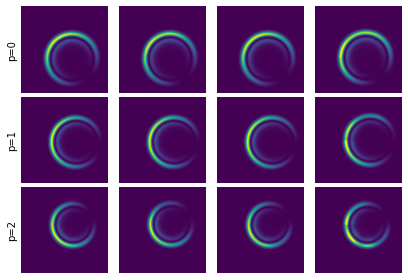

In [20]:
images = np.array(training_data[0].to('cpu')) # [KP, 2X+1, 2X+1] uint8 in device

fig, ax_array = plt.subplots(P, K)
for p in range(P):
    ax_array[p][0].set_ylabel(f"p={p}")
    for k in range(K):
        ax_array[p][k].imshow(images[K*p+k])
plt.setp(ax_array, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.4, w_pad=0.0001)

In [39]:
from sklearn.decomposition import PCA
import plotly.express as px
from umap import UMAP
X21=2*X+1
# Get the Embeddings and the Images to plot
model.eval()
embeddings = np.zeros(( P_to_embedd*K_to_embedd, out_fc2), dtype=np.float32)

# x,y are only required for the plotting within the 2D PCA and UMAP
x = np.zeros( ( P_to_embedd*K_to_embedd, X21**2), dtype=np.uint8)
y = np.zeros(( P_to_embedd*K_to_embedd), dtype=np.float32)


for p in range(P_to_embedd):
    images, label = test_data.get_im_and_label() # [ K_to_embedd, 2X+1, 2X+1]
    embeddings[ K_to_embedd*p:(K_to_embedd*(p+1)), :] = np.array(model(images).detach().to('cpu')) # [ K_to_embedd, embedding_dim]
    
    x[K_to_embedd*p:(K_to_embedd*(p+1)), :] = np.array(images.to('cpu')).reshape(4, X21**2)
    y[K_to_embedd*p:(K_to_embedd*(p+1))] = label.item()

df = pd.DataFrame({'y':y})
df['phiCR'] = df["y"].astype(str)


In [ ]:
# If willing to use an already generated test visualization
#df = pd.read_pickle(save_stuff_path+f"/Test_Visualization_df_TalTal_{exp_name}.pkl")

## PCA to 2D

In [41]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(embeddings)
# step optimizable!
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df['principal component 1 2D'] = principalDf['principal component 1']
df['principal component 2 2D'] = principalDf['principal component 2']

In [42]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.palettes import Spectral10

output_notebook()

def embeddable_image(data):
    img_data = data.values.reshape(X21,X21)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

df['image'] = pd.DataFrame(data=x, columns=list(range(x.shape[1]))).apply(embeddable_image, axis=1)

datasource = ColumnDataSource(df)
color_mapping = LinearColorMapper(
    palette='Magma256',
    low=y.min(),
    high=y.max()
)

plot_figure = figure(
    title='PCA projection of the CR dataset',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>phiCR:</span>
        <span style='font-size: 18px'>@phiCR</span>
    </div>
</div>
"""))

plot_figure.circle(
    'principal component 1 2D',
    'principal component 2 2D',
    source=datasource,
    color=dict(field='phiCR', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=7
)
show(plot_figure)

Loading BokehJS ...

## PCA to 3D

In [43]:
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(embeddings)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
df['principal component 1 3D'] = principalDf['principal component 1']
df['principal component 2 3D'] = principalDf['principal component 2']
df['principal component 3 3D'] = principalDf['principal component 3']

In [44]:
fig=px.scatter_3d(df, x="principal component 1 3D", y="principal component 2 3D", z="principal component 3 3D", color="y")
fig.update_traces(marker={"size":3})
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()

## UMAP to 2D

In [45]:
umap_reducer = UMAP(n_components=2, min_dist=0.1, n_neighbors=500, metric='hamming')
principalComponents = umap_reducer.fit_transform(embeddings)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['umap_1', 'umap_2'])
df['umap_1 2D'] = principalDf['umap_1']
df['umap_2 2D'] = principalDf['umap_2']

/home/oiangu/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning:

gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable

/home/oiangu/anaconda3/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



In [46]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.palettes import Spectral10

output_notebook()

def embeddable_image(data):
    img_data = data.values.reshape(X21,X21)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

df['image'] = pd.DataFrame(data=x, columns=list(range(x.shape[1]))).apply(embeddable_image, axis=1)


datasource = ColumnDataSource(df)
color_mapping = LinearColorMapper(
    palette='Magma256',
    low=y.min(),
    high=y.max()
)

plot_figure = figure(
    title='UMAP projection of the CR dataset',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>phiCR:</span>
        <span style='font-size: 18px'>@phiCR</span>
    </div>
</div>
"""))

plot_figure.circle(
    'umap_1 2D',
    'umap_2 2D',
    source=datasource,
    color=dict(field='phiCR', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=7
)
show(plot_figure)

Loading BokehJS ...

## UMAP to 3D

In [47]:
from umap import UMAP

umap_reducer = UMAP(n_components=3, min_dist=0.1, n_neighbors=400, metric='hamming') #euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
principalComponents = umap_reducer.fit_transform(embeddings)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['umap_1', 'umap_2', 'umap_3'])
df['umap_1 3D'] = principalDf['umap_1']
df['umap_2 3D'] = principalDf['umap_2']
df['umap_3 3D'] = principalDf['umap_3']

/home/oiangu/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning:

gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable

/home/oiangu/anaconda3/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



In [48]:
fig=px.scatter_3d(df, x="umap_1 3D", y="umap_2 3D", z="umap_3 3D", color="y")
fig.update_traces(marker={"size":3})
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()

Save the embedding visualizations.

In [ ]:
df.to_pickle(save_stuff_path+f"/Test_Visualization_df_{datetime.now()}_{exp_name}.pkl") 

## Test Jungle

In [ ]:
a=torch.ones((2, 5))
b=3*a
c=6*a
d = torch.stack((a,b,c), axis=0)
print(d.shape)

In [ ]:
d

In [ ]:
e = d.reshape(3*2, 5)
print(e)

In [ ]:
distances = torch.pdist(e, p=2)
D = torch.zeros((3*2, 3*2))

triu_indices = torch.triu_indices(row=3*2, col=3*2, offset=1)
D[triu_indices[0], triu_indices[1]] = distances
D.T[triu_indices[0], triu_indices[1]]= distances

print(D)

In [ ]:
b=np.array([1,2,3])
c=np.array([3,4,7])
np.linalg.norm(c-2*b)

In [ ]:
a = torch.tensor([[1,2,3],[3,8,3],[3,4,7], [2,4,6]], dtype=torch.float32)
d = torch.pdist(a, p=2)

In [ ]:
d

In [ ]:
m = torch.zeros((4, 4), device=device)

triu_indices = torch.triu_indices(row=4, col=4, offset=1)
print(triu_indices)
m[triu_indices[0], triu_indices[1]] = d.to(device)

In [ ]:
m.T[triu_indices[0], triu_indices[1]]=d.to(device)
#m.diagonal=torch.Tensor([1,1,1,1]).to(device)

In [ ]:
m

In [ ]:
b = m+torch.diag(torch.tensor([float('inf')]*4, device=device))
print(b)

In [ ]:
print(torch.min(m))
print(torch.min(b))

In [ ]:
K=2

a=torch.ones((K,K), dtype=torch.bool, device=device)

P=2
diag_1s = torch.kron(torch.eye(P, dtype=torch.bool, device=device),a)
diag_0s = torch.logical_not(diag_1s)
print(diag_0s)

In [ ]:
m.dtype

In [ ]:
positives = torch.where(diag_1s, m, torch.tensor([0.0], device=device))
negatives = torch.where(diag_1s, torch.tensor([torch.inf], device=device), m)

In [ ]:
negatives

In [ ]:
hard_positives = torch.max(positives, axis=0)[0]

In [ ]:
hard_negatives = torch.min(negatives, axis=0)[0]

In [ ]:
marg=1.0
r=nn.ReLU()
torch.sum(r(marg+hard_positives-hard_negatives))

In [ ]:
marg+hard_positives-hard_negatives

In [ ]:
m[diag_1s] = 989

In [ ]:
m